In [1]:
import tensorflow.compat.v2 as tf
import ddsp.training
_AUTOTUNE = tf.data.experimental.AUTOTUNE
from IPython.display import Audio, display
from livelossplot import PlotLosses
import numpy as np
import random 
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# define constants
N_SAMPLES=16000*4
SAMPLE_RATE=16000

SEED=1

tf.random.set_seed(
    SEED
)
np.random.seed(SEED)
random.seed(SEED)



# define some utilis
def play(audio):
  display(Audio(audio,rate=SAMPLE_RATE))

class CustomNSynthTfds(ddsp.training.data.TfdsProvider):
  """Parses features in the TFDS NSynth dataset.
  If running on Cloud, it is recommended you set `data_dir` to
  'gs://tfds-data/datasets' to avoid unnecessary downloads.
  """

  def __init__(self,
               name='nsynth/gansynth_subset.f0_and_loudness:2.3.3',
               split='train',
               data_dir='gs://tfds-data/datasets',
               sample_rate=16000,
               frame_rate=250,
               include_note_labels=True):
    """TfdsProvider constructor.
    Args:
      name: TFDS dataset name (with optional config and version).
      split: Dataset split to use of the TFDS dataset.
      data_dir: The directory to read the prepared NSynth dataset from. Defaults
        to the public TFDS GCS bucket.
      sample_rate: Sample rate of audio in the dataset.
      frame_rate: Frame rate of features in the dataset.
      include_note_labels: Return dataset without note-level labels
        (pitch, instrument).
    """
    self._include_note_labels = include_note_labels

    super().__init__(name, split, data_dir, sample_rate, frame_rate)

  def get_dataset(self, shuffle=True):
    """Returns dataset with slight restructuring of feature dictionary."""
    def preprocess_ex(ex):
      ex_out = {
          'audio':
              ex['audio'],
          'f0_hz':
              ex['f0']['hz'],
          'f0_confidence':
              ex['f0']['confidence'],
          'loudness_db':
              ex['loudness']['db'],
      }
      if self._include_note_labels:
        ex_out.update({
            'pitch':
                ex['pitch'],
            'velocity':
                ex['velocity'],
            'instrument_source':
                ex['instrument']['source'],
            'instrument_family':
                ex['instrument']['family'],
            'instrument':
                ex['instrument']['label'],
        })
      return ex_out

    dataset = super().get_dataset(shuffle)
    dataset = dataset.map(preprocess_ex, num_parallel_calls=_AUTOTUNE)
    return dataset

tfds=tfds.load("nsynth/gansynth_subset.f0_and_loudness",split="train", try_gcs=False,download=True) 

# intialize nsynth dataset
data_provider = CustomNSynthTfds(data_dir="/root/tensorflow_datasets/",split="train")

/usr/local/lib/python3.6/dist-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
tf.config.list_physical_devices('GPU')
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True


In [3]:
# play one sound
batched_dataset = data_provider.get_batch(1)

test_batch = next(iter(batched_dataset))

play(tf.reshape(test_batch["audio"],(-1)))

test_batch.keys()

dict_keys(['audio', 'f0_hz', 'f0_confidence', 'loudness_db', 'pitch', 'velocity', 'instrument_source', 'instrument_family', 'instrument'])

In [4]:
# take a batch of flute sounds
#dataset = data_provider.get_dataset()

# take only acoustic sounds
#dataset=dataset.filter(lambda x: x["instrument_source"]==0)

# take only flute sounds
#dataset=dataset.filter(lambda x: x["instrument_family"]==3)

# flutes
# 2965 samples
# 36 instruments
# 5 velocities 
# 61 pitches

#test_batch=next(iter(dataset.batch(4))) 

#play(tf.reshape(test_batch["audio"],(-1)))

In [5]:
N_NOISE_MAGNITUDES=64
N_HARMONICS=64

class LGD(ddsp.training.models.Model):

    def __init__(self, n_out,  rnn_channels=256, rnn_type='gru', ch=512, layers_per_stack=0, name=None):
        super().__init__(name=name)

        def stack():
            return ddsp.training.nn.FcStack(ch, layers_per_stack)

        self.input_keys = ["f0_hz", "ld_scaled"]

        self.n_out = n_out
        self.input_stacks = [stack() for k in self.input_keys]

        self.rnn = ddsp.training.nn.Rnn(rnn_channels, rnn_type)
        self.out_stack = stack()
        self.dense_out = ddsp.training.nn.Fc(self.n_out)

    def call(self, conditioning):


        instrument_representation = conditioning["instrument_embeddings"]

        feature_len = conditioning["f0_scaled"].shape[1]

        instrument_representation = tf.repeat(
            instrument_representation[:, None, ...], feature_len, axis=1)

        inputs = [conditioning[k] for k in self.input_keys]

        inputs = [stack(x) for stack, x in zip(self.input_stacks, inputs)]

        x = tf.concat(inputs, axis=(-1))
        x = tf.concat([x, instrument_representation], axis=2)
        x = self.rnn(x)
        x = tf.concat((inputs + [x]), axis=(-1))
        x = self.out_stack(x)
        out = self.dense_out(x)
        return out

preprocessor=ddsp.training.preprocessing.F0LoudnessPreprocessor()
decoder = LGD(n_out=N_NOISE_MAGNITUDES+N_HARMONICS+1)

harmonic_synth = ddsp.synths.Harmonic(
    n_samples=N_SAMPLES, sample_rate=SAMPLE_RATE, name='harmonic')

filtered_noise = ddsp.synths.FilteredNoise(
    n_samples=N_SAMPLES, window_size=0, initial_bias=-10.0, name='filtered_noise')
add = ddsp.processors.Add(name='add')

spectral_loss = ddsp.losses.SpectralLoss(loss_type='L1',
                                              mag_weight=1.0,
                                              logmag_weight=1.0)


In [6]:
BATCH_SIZE=16

batched_dataset= data_provider.get_batch(BATCH_SIZE,shuffle=True)

batch={k:ft[:BATCH_SIZE] for k,ft in test_batch.items() }

INSTRUMENT_EMBEDDING_SIZE=256

instrument_embedding_dict = {}


plotlosses = PlotLosses()

e=0


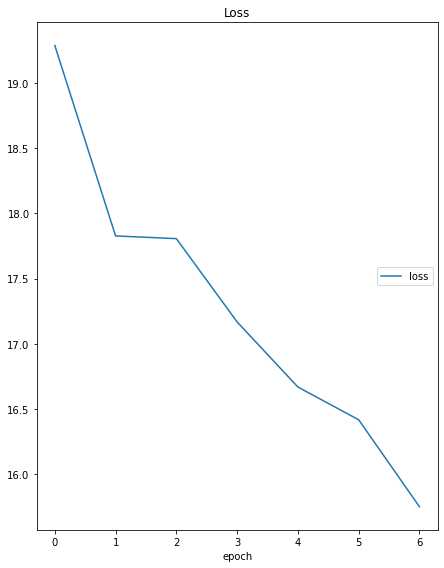

Loss
	loss             	 (min:   15.753, max:   19.287, cur:   15.753)
summary nr: 350


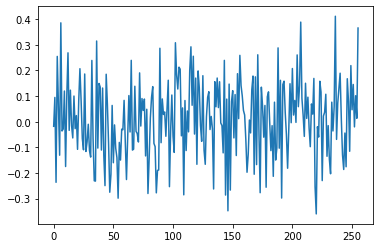

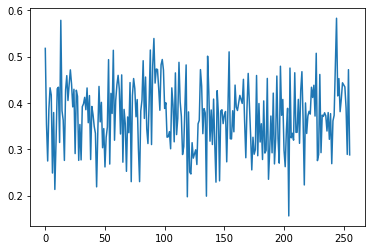

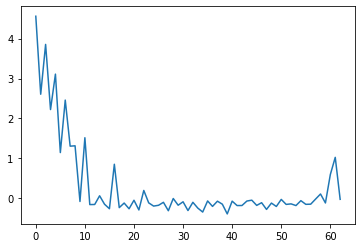

tf.Tensor(15.561888, shape=(), dtype=float32)


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-3)

summary_loss=0
summary_interval = 50
while True:
  for batch in batched_dataset:
    batch_instrument_embeddings=[]
    for sample_index in range(batch["instrument"].shape[0]):
      instrument_id=batch["instrument"][sample_index].numpy()
      if instrument_id not in instrument_embedding_dict:
        instrument_embedding_dict[instrument_id]=tf.random.normal([INSTRUMENT_EMBEDDING_SIZE])
      batch_instrument_embeddings.append(instrument_embedding_dict[instrument_id])
    batch_instrument_embeddings_tf = tf.Variable(tf.stack(batch_instrument_embeddings))   
    with tf.GradientTape() as tape:
      pp_batch=preprocessor(batch, training=True)
      pp_batch["instrument_embeddings"]=tf.tanh(batch_instrument_embeddings_tf)
        
      for k in pp_batch.keys():
          tf.debugging.check_numerics(pp_batch[k],"failed numerics check")
    
      d_batch=decoder(pp_batch, training=True)
    
      noise_magnitudes = d_batch[:,:,:N_NOISE_MAGNITUDES]
      harmonic_distribution = d_batch[:,:,-N_HARMONICS:-1]
      loudness=d_batch[:,:,-1:]
      noise_part = filtered_noise(noise_magnitudes)
      harmonic_part = harmonic_synth(loudness,harmonic_distribution,pp_batch["f0_hz"])
      yhat=noise_part+harmonic_part
    
      tf.debugging.check_numerics(yhat,"failed numerics check")

      loss_value=spectral_loss(batch["audio"],yhat)
        

      gradients = tape.gradient(loss_value, [batch_instrument_embeddings_tf,*decoder.trainable_variables])
      gradients, _ = tf.clip_by_global_norm(gradients, 5.0)

      summary_loss+=loss_value
    
    optimizer.apply_gradients(zip(gradients, [batch_instrument_embeddings_tf,*decoder.trainable_variables]))
    for sample_index in range(batch["instrument"].shape[0]):
      # TODO: average instrument embeddings per instrument
      instrument_embedding_dict[instrument_id]=batch_instrument_embeddings_tf[sample_index]
    
    if e>0 and e%summary_interval==0:
        
      plotlosses.update({
        'loss': summary_loss/summary_interval,
      })
    
      summary_loss=0
        
      plotlosses.send()
    
      print(f"summary nr: {e}")
        
      plt.plot(tf.math.reduce_mean(pp_batch["instrument_embeddings"],axis=[0]))
      plt.show()

      plt.plot(tf.math.reduce_variance(pp_batch["instrument_embeddings"],axis=[0]))
      plt.show()
  
      plt.plot(harmonic_distribution[0,100,:])
      plt.show()
      print(loss_value)
      play(tf.reshape(batch["audio"],(-1)))
      play(tf.reshape(yhat,(-1)))
    
    e+=1

In [ ]:
play(tf.reshape(batch["audio"],(-1)))
play(tf.reshape(yhat,(-1)))

In [ ]:
!nvidia-smi